https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf

In [1]:
import sys
import os
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
REPO_ROOT="C://Users//ericf//source//repos//text-inferences"


### shouldn't need to modify these
CORPUS = os.path.join(REPO_ROOT,'corpora','ifrc_evaluations')
INTERMEDIATES = os.path.join('.','file_intermediates')
sys.path.append(os.path.join(REPO_ROOT,'src','common_functions'))




In [3]:
from tqdm.auto import tqdm

import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None)

import re

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_md")


from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.decomposition import NMF


# Load Pre-processed Data

In [4]:
def load_sentence_level_content(location, file='eval_sents.pkl'):
    source = os.path.join(location,file)
    df_sentences = pd.read_pickle(source)
    
    print(f"df_sentences loaded with shape: {df_sentences.shape}")
    
    return df_sentences
    
df_sentences = load_sentence_level_content(INTERMEDIATES)

df_sentences loaded with shape: (276401, 3)


In [5]:
def load_paragraph_level_content(location, file='evals_by_paragraph.csv'):
    source = os.path.join(location,file)
    df_paragraph = pd.read_csv(source)
    
    print(f"df_paragraph loaded with shape: {df_paragraph.shape}")
    
    return df_paragraph
    

df_paragraphs = load_paragraph_level_content(INTERMEDIATES)

df_paragraph loaded with shape: (89513, 3)


In [6]:
def generate_file_level_from_sentence_level_df(df):
    docs = []
    for document in df['file'].unique().tolist():
        doc_text = ' '.join(df['original_text'][df['file'] == document].tolist())
        docs.append([document, doc_text, document[0:4]])
    
    df_files = pd.DataFrame(docs, columns=['file','original_text','year'])
    
    print(f"df_files loaded with shape: {df_files.shape}")
    
    return df_files

df_files = generate_file_level_from_sentence_level_df(df_sentences)

df_files loaded with shape: (391, 3)


In [7]:
def standardized_df_structure(df):
    
    #make sure there's a year column
    if 'year' in df.columns:
        pass
    else:
        df['year'] = df['file'].str[0:4].astype(int, errors='ignore')
        
    
    #add this later
    #df['num_tokens'] = df['tokens'].apply(lambda x: len(x))
        

        
    # remove rows where the year is not 4 digits
    len_before_removal = len(df)
    df = df[df['year'].astype(str).str.match(r'^\d{4}$')]
   #df['year'] = df['year'].astype(int)
    len_after_removal = len(df)
    print(f"removed {(len_before_removal - len_after_removal) / len_before_removal}%\
of rows ({len_before_removal - len_after_removal}) because year format was wrong")
        
        
    return df


df_files = standardized_df_structure(df_files)
df_paragraphs = standardized_df_structure(df_paragraphs)
df_sentences = standardized_df_structure(df_sentences)
    


removed 0.0025575447570332483%of rows (1) because year format was wrong
removed 1.1171561672606214e-05%of rows (1) because year format was wrong
removed 0.0030173552194094812%of rows (834) because year format was wrong


In [8]:

#consider deleting but may need to keep
#df_main = df[df['original_text'].str.len() > 80]

## Define Functions to Analyze and Report on Topics

In [9]:
#This takes in docs at any arbitrary level of granularity


def analyze_topics(df, field_to_vectorize='original_text'):
    
    
    tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
    tfidf_vectors = tfidf_vectorizer.fit_transform(df[field_to_vectorize])
    #tfidf_vectors = tfidf_vectorizer.fit_transform(df['preprocessed_text'])
    
    tfidf_vectors.shape

    nmf_text_model = NMF(n_components=30, random_state=42)

    W_text_matrix = nmf_text_model.fit_transform(tfidf_vectors)
    H_text_matrix = nmf_text_model.components_
    
    
    #googled...
    normalized_doc_topic_matrix = W_text_matrix / W_text_matrix.sum(axis=1, keepdims=True)
    
    
    def display_topics(model, features, no_top_words=8):
        topic_terms = []
        for topic, word_vector in enumerate(model.components_):
            total = word_vector.sum()
            largest = word_vector.argsort()[::-1]
            #print(f"\nTopic {topic}")
            
            keywords = []
            topic_characteristics = []

            for i in range(0, no_top_words):
                topic_characteristics.append(features[largest[i]])
                keywords.append(features[largest[i]])

                #print(" %s (%2.2f)" % (features[largest[i]],
                #                      word_vector[largest[i]]*100.0/total))
            topic_characteristics.append(', '.join(keywords))
            topic_terms.append(topic_characteristics)
        
        # TODO ... this part can be eliminated if we bring it to the loop just above
        cols=["h1","h2","h3","h4","h5","h6","h7","h8"]
        #for i in range(0,8):
        #    cols.append(str(i))

        #cols = [*range(0,8)]
        cols.append('keywords')
        df_topic_info = pd.DataFrame(topic_terms, columns=cols)
        
        #cols = np.arange(0,no_top_words)
        #cols = np.append(cols, 'keywords')
        #df_topic_info = pd.DataFrame(topic_terms, columns=cols)
        
        return df_topic_info
    
    ## summarize the topic info in a dataframe and give it a title consisting of the top
    ## two words in the topic
    df_topic_info = display_topics(nmf_text_model, tfidf_vectorizer.get_feature_names_out())
    df_topic_info['title'] = df_topic_info.apply(lambda x: x[0] + ' ' + x[1], axis=1)
    #df_topic['keywords'] = df_topic_info
    
    
    return df_topic_info, normalized_doc_topic_matrix




## iterate through the topics and text and allocate them to each


def get_dominant_topic(normalized_doc_topic_matrix, df_topic_info, df_doc_info, dominance=0.25):
    idx = 0
    rows=[]
    
    for topic_values in tqdm(normalized_doc_topic_matrix):
        maxid = pd.Series(topic_values).fillna(0).idxmax() #get the index of the max value
        #print(f"{maxid} ddddd {topic_values[maxid]}")
        if topic_values[maxid] > dominance:
            rows.append([idx,df_topic_info.iloc[maxid]['title'],df_topic_info.iloc[maxid]['keywords'],df_doc_info.iloc[idx]['file']])
            #print(f"{idx} : {df_topic_info.iloc[maxid]['title']} : {df_doc_info.iloc[idx]['file']}")
        else:
            rows.append([idx,'no dominant topic found','NA',df_doc_info.iloc[idx]['file']])
           # print(f"{idx} : topics too diffused to identify dominant topic {topic_values[maxid]}")
        idx +=1
    
    df_topic_summary = pd.DataFrame(rows,columns=['index_val','topic_title','topic_keywords','file_name'])
    return df_topic_summary



def get_dominant_sub_file_topic(normalized_doc_topic_matrix, df_topic_info, df_doc_info, dominance=0.25):
    idx = 0
    rows=[]
    
    for topic_values in tqdm(normalized_doc_topic_matrix):
        maxid = pd.Series(topic_values).fillna(0).idxmax() #get the index of the max value
        #print(f"{maxid} ddddd {topic_values[maxid]}")
        if topic_values[maxid] > dominance:
            rows.append([idx,df_topic_info.iloc[maxid]['title'],df_topic_info.iloc[maxid]['keywords'],df_doc_info.iloc[idx]['original_text'],df_doc_info.iloc[idx]['file']])
            #print(f"{idx} : {df_topic_info.iloc[maxid]['title']} : {df_doc_info.iloc[idx]['file']}")
        else:
            rows.append([idx,'no dominant topic found','NA',df_doc_info.iloc[idx]['original_text'],df_doc_info.iloc[idx]['file']])
           # print(f"{idx} : topics too diffused to identify dominant topic {topic_values[maxid]}")
        idx +=1
    
    df_topic_summary = pd.DataFrame(rows,columns=['index_val','topic_title','topic_keywords','original_text','file_name'])
    return df_topic_summary




## Perform Analysis at the FILE level

In [10]:

df_topic_info__file, normalized_topic_matrix__file = analyze_topics(df_files)

df_topic_summary__file = get_dominant_topic(normalized_topic_matrix__file, df_topic_info__file, df_files)



C:\Users\ericf\anaconda3\envs\text-inferences\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


  0%|          | 0/390 [00:00<?, ?it/s]

In [11]:
df_topic_summary__file[['topic_title','topic_keywords','file_name']].groupby(['topic_title','topic_keywords']).count().sort_values(by='file_name', ascending=False)[2:]

,,file_name
topic_title,topic_keywords,
shelter cluster,"shelter, cluster, esc, haiti, agencies, sct, coordinator, clusters",21
respondents survey,"respondents, survey, households, figure, household, baseline, percent, latrine",19
dref operation,"dref, operation, workshop, lrc, items, zrcs, learned, operations",19
ns nss,"ns, nss, ocac, nsd, secretariat, icrc, rc, pmer",19
zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",18
cbdrr indonesia,"cbdrr, indonesia, pmi, tsunami, resilience, lanka, sri, resilient",17
law idrl,"law, idrl, legal, volunteering, act, regulation, samoa, relief",14
slrcs sri,"slrcs, sri, lanka, houses, tsunami, housing, construction, house",13
hiv aids,"hiv, aids, peer, plhiv, condom, educators, alliance, blood",13


In [12]:
# Explore different topics
df_topic_summary__file[df_topic_summary__file['topic_title'] == 'zrcs cash']

,index_val,topic_title,topic_keywords,file_name
36,36,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2009_evaluation_of_the_red_cross_response_to_typhoons_ketsana_and_mirinae_disasters_in_viet_nam.txt
113,113,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2013_external_end_of_project_evaluation_of_the_food_security_project_supported_by_the_japanese_government_and_implemented_by_ifrc_zrcs.txt
182,182,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2014_zimbabwe_food_insecurity_emergency_appeal_evaluation_report.txt
203,203,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2015_zimbabwe_floods_dref_review_final_report.txt
204,204,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2015_zimbabwe_food_security_emergency_appeal_evaluation.txt
209,209,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2016_end_of_project_evaluation_chivi_water_sanitation_and_hygiene_project_chiwash_.txt
216,216,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2016_final_evaluation_of_the_social_and_economic_reintegration_pilot_program_icrc_brc.txt
226,226,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2016_malawi_food_insecurity_evaluation.txt
239,239,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2016_tigray_food_security_evaluation_report.txt
242,242,zrcs cash,"zrcs, cash, households, appeal, zimbabwe, gardens, household, drought",2016_viet_nam_safer_homes_safer_communities.txt


## Perform Analysis at PARAGRAPH Level

In [13]:
#df_paragraph

df_topic_info__para, normalized_topic_matrix__para = analyze_topics(df_paragraphs)

df_topic_summary__para = get_dominant_sub_file_topic(normalized_topic_matrix__para, df_topic_info__para, df_paragraphs)



C:\Users\ericf\anaconda3\envs\text-inferences\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\ericf\AppData\Local\Temp\ipykernel_21324\2974977181.py:20: RuntimeWarning: invalid value encountered in divide
  normalized_doc_topic_matrix = W_text_matrix / W_text_matrix.sum(axis=1, keepdims=True)


  0%|          | 0/89512 [00:00<?, ?it/s]

In [14]:


df_topic_summary__para[['topic_title','topic_keywords','file_name']].groupby(['topic_title','topic_keywords']).count().sort_values(by='file_name', ascending=False)

,,file_name
topic_title,topic_keywords,
no dominant topic found,NA,10459
beneficiaries cash,"beneficiaries, cash, food, people, households, beneficiary, affected, assistance",7733
de la,"de, la, en, el, los, las, que, para",5409
red cross,"red, cross, crescent, international, federation, societies, movement, society",5180
12 11,"12, 11, figure, 13, 14, 15, 18, 19",5156
volunteers training,"volunteers, training, staff, volunteer, branch, trained, activities, skills",4703
ifrc org,"ifrc, org, office, appeal, secretariat, country, www, team",3817
community communities,"community, communities, based, resilience, members, program, risk, local",3674
support coordination,"support, coordination, operation, capacity, ns, level, movement, needs",3592


In [15]:
df_topic_summary__para[df_topic_summary__para['topic_title']  == 'recommendations conclusions'].sample(3)

,index_val,topic_title,topic_keywords,original_text,file_name
45217,45217,recommendations conclusions,"recommendations, conclusions, lessons, future, learned, main, conclusion, learnt",Beneficiary Selection P rocess Recommendations (future programmes ) – \napplicable for any sector,2015_mid_term_review_brc_prc_typhoon_haiyan_iloilo_recovery_programme.txt
16719,16719,recommendations conclusions,"recommendations, conclusions, lessons, future, learned, main, conclusion, learnt","\n6. 0 Recommendations \n6. 1 Operations Management \nSome fundamental aspects of operations management were lacking during the operation. These included \nexperienced, skilled human resource capacities in the Zone office, inadequate management response to the \nevolving situation and lack of clear roles and responsibilities. The following recommendations are made to \nimprove the current and future operations management:",2011_real_time_evaluation_of_the_international_federation_of_red_cross_and_red_crescent_societies_response_to_the_mena_civil_unrest.txt
32735,32735,recommendations conclusions,"recommendations, conclusions, lessons, future, learned, main, conclusion, learnt","31 \n 6. Recommendations \nThese recommendations for cholera epidemic response are based on findings in the \nSierra Leone response and may or may not be appropriate for other context. In Sierra \nLeone there existed a reasonably strong health ministry, a strong national society with \ngood relations with the government health services, an absence of stigma surrounding \ncholera and a lack of violence and open access to all affected communities.",2013_sierra_leone_cholera_eru_operation_review.txt


## Perform Analysis at SENTENCE Level

In [16]:
df_sentences.sample()

,file,original_text,preprocessed_text,year
79836,2013_benin_floods_cholera_and_fire.txt,Siège \n Bonne volonté des cadres \n,"[siege, bonne, volonte, des, cadre]",2013


In [17]:
##test
df_sentences['preprocessed'] = df_sentences['preprocessed_text'].apply(lambda x: ' '.join(x))


In [18]:
#df_paragraph

df_topic_info__sent, normalized_topic_matrix__sent = analyze_topics(df_sentences, field_to_vectorize='preprocessed')

df_topic_summary__sent = get_dominant_sub_file_topic(normalized_topic_matrix__sent, df_topic_info__sent, df_sentences)

C:\Users\ericf\anaconda3\envs\text-inferences\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\ericf\AppData\Local\Temp\ipykernel_21324\2974977181.py:20: RuntimeWarning: invalid value encountered in divide
  normalized_doc_topic_matrix = W_text_matrix / W_text_matrix.sum(axis=1, keepdims=True)


  0%|          | 0/275567 [00:00<?, ?it/s]

In [19]:
df_topic_summary__sent[['topic_title','topic_keywords','file_name']].groupby(['topic_title','topic_keywords']).count().sort_values(by='file_name', ascending=False)

,,file_name
topic_title,topic_keywords,
no dominant topic found,NA,40008
de la,"de, la, en, el, los, las, que, del",22187
people household,"people, household, year, family, house, number, total, affect",21754
red cross,"red, cross, crescent, international, federation, societies, movement, society",11173
level local,"level, local, district, coordination, government, branch, country, high",10533
provide information,"provide, information, service, assistance, datum, material, share, good",10307
project implementation,"project, implementation, objective, impact, design, result, implement, achieve",9991
disaster management,"disaster, management, risk, reduction, law, preparedness, international, gender",8729
capacity building,"capacity, building, ns, build, resource, strengthen, development, increase",8001


In [20]:
df_topic_summary__sent[df_topic_summary__sent['topic_title'] == 'key recommendations']

,index_val,topic_title,topic_keywords,original_text,file_name


## Explore a Specific File



In [22]:
#df_specific_doc_sent_level

In [23]:
#lets get this file:

#df_specific_doc_sent_level = df_sentences[df_sentences['file'] == '2015_chernobyl_humanitarian_assistance_and_rehabilitation_programme_charp_.txt']

#df_specific_doc_sent_level = df_specific_doc_sent_level.reset_index()

#df_sent_topic_info, normalized_sent_topic_matrix = analyze_topics(df_specific_doc_sent_level, field_to_vectorize='preprocessed')
#df_sent_topic_summary = get_dominant_topic(normalized_sent_topic_matrix, df_sent_topic_info, df_specific_doc_sent_level)
#df_sent_topic_summary.groupby(['topic_title','topic_keywords']).count().sort_values(by='index_val', ascending=False)


In [24]:
#indices = df_topic_summary['index_val'][df_topic_summary['topic_title'] == 'yabc programme'].tolist()

In [25]:
#df_specific_doc_sent_level.iloc[indices]

# Init Charting

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt



# Chart Topics by Year

In [27]:
def chart_topics_by(df, field_to_vectorize='original_text', by='year'):
    
    
    tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
    tfidf_vectors = tfidf_vectorizer.fit_transform(df[field_to_vectorize])
    #tfidf_vectors = tfidf_vectorizer.fit_transform(df['preprocessed_text'])
    
    tfidf_vectors.shape

    nmf_text_model = NMF(n_components=50, random_state=42)

    W_text_matrix = nmf_text_model.fit_transform(tfidf_vectors)
    H_text_matrix = nmf_text_model.components_
    
    
    #googled...
    normalized_doc_topic_matrix = W_text_matrix / W_text_matrix.sum(axis=1, keepdims=True)
    
    
    def display_topics(model, features, no_top_words=8):
        topic_terms = []
        for topic, word_vector in enumerate(model.components_):
            total = word_vector.sum()
            largest = word_vector.argsort()[::-1]
            #print(f"\nTopic {topic}")
            
            keywords = []
            topic_characteristics = []

            for i in range(0, no_top_words):
                topic_characteristics.append(features[largest[i]])
                keywords.append(features[largest[i]])

                #print(" %s (%2.2f)" % (features[largest[i]],
                #                      word_vector[largest[i]]*100.0/total))
            topic_characteristics.append(', '.join(keywords))
            topic_terms.append(topic_characteristics)
        
        cols = [*range(0,8)]
        cols.append('keywords')
        df_topic_info = pd.DataFrame(topic_terms, columns=cols)
        
        return df_topic_info
    
    ## summarize the topic info in a dataframe and give it a title consisting of the top
    ## two words in the topic
    df_topic_info = display_topics(nmf_text_model, tfidf_vectorizer.get_feature_names_out())
    df_topic_info['title'] = df_topic_info.apply(lambda x: x[0] + ' ' + x[1], axis=1)
    
    topic_names = []

    # why doesn't this work?
    topic_names = df_topic_info['title'].unique().tolist()
    # trying this instead
    #topic_names = list(set(df_topic_info['title'].tolist()))

    
    year_data = []
    years = np.unique(df_sentences['year'])
    for year in tqdm(years):
        W_year = nmf_text_model.transform(tfidf_vectors[np.array(df['year'] == year)])
        year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))
    
    df_year = pd.DataFrame(year_data, columns = ["year"] + topic_names).set_index("year")
    df_year.plot.area(figsize=(16,9))
    
    
    
    return df_topic_info, normalized_doc_topic_matrix

In [ ]:
#df_ti, ndtm = chart_topics_by(df_sentences, field_to_vectorize='preprocessed')

In [28]:
from collections import Counter

# heatmap
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]


def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    #print(f"f is {freq_matrix}")
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    print(freq_matrix.shape)
    freq_df[by] = df[by] # copy the grouping columns
    
    return freq_df.groupby(by=by).sum().sort_values(by)

keywords = ['health','hygiene','hiv','ebola','cholera','shelter','livelihood','cash','food',
           'vulnerable','gender','age']



(275567,)


<Axes: xlabel='year'>

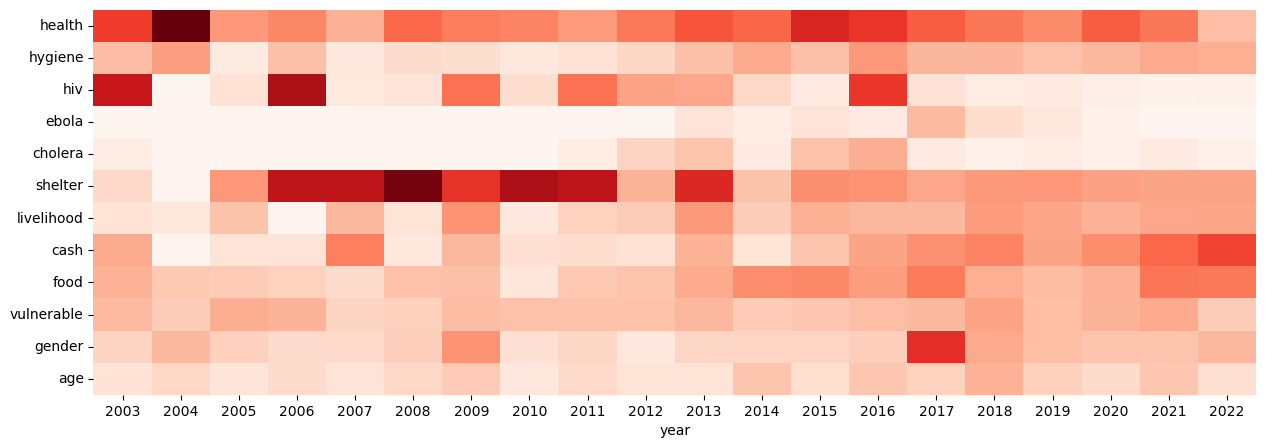

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))



freq_df = count_keywords_by(df_sentences, by='year', keywords=keywords, column='preprocessed_text')
df_sentences['num_tokens'] = df_sentences['preprocessed_text'].apply(lambda x: len(x))

freq_df = freq_df.div(df_sentences.groupby('year')['num_tokens'].sum(), axis=0)
freq_df = freq_df.apply(np.sqrt)

df_display = freq_df.head(20)


sns.heatmap(data=df_display.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")

# By Topic @ File-Level Granularity

In [30]:
print(df_files.shape) ## content
print(df_topic_info__file.shape) ## topics
print(normalized_topic_matrix__file.shape) ## matrix of topic strengths
print(df_topic_summary__file.shape) ## dominant topic

(390, 3)
(30, 10)
(390, 30)
(390, 4)


In [31]:
## NO IDEA why I have to do this, but if I try to .unique().list() directly to df_topic_info__file I get an error
df_foo = df_topic_info__file[['keywords','title']]
topic_headers = df_foo['title'].unique().tolist()


In [32]:
#join the headers and matrix together in one DF
df_topics_and_strengths = pd.DataFrame(normalized_topic_matrix__file, columns=topic_headers)

#then merge them with the file data dataframe... dropping a few unecessary columns
df_files_and_topics_for_charting = df_files.merge(df_topics_and_strengths, left_index=True, right_index=True)
df_files_and_topics_for_charting.drop(inplace=True, columns=['file','original_text','de la'])


In [33]:
#format data for charting... may need to experiment to make sure you have a reaonsable operation
#(sum) or (mean), does each segment have the right amount of data? etc
df_chrt = df_files_and_topics_for_charting.groupby('year').mean()
df_chrt = df_chrt.iloc[8:-1]

<Axes: xlabel='year'>

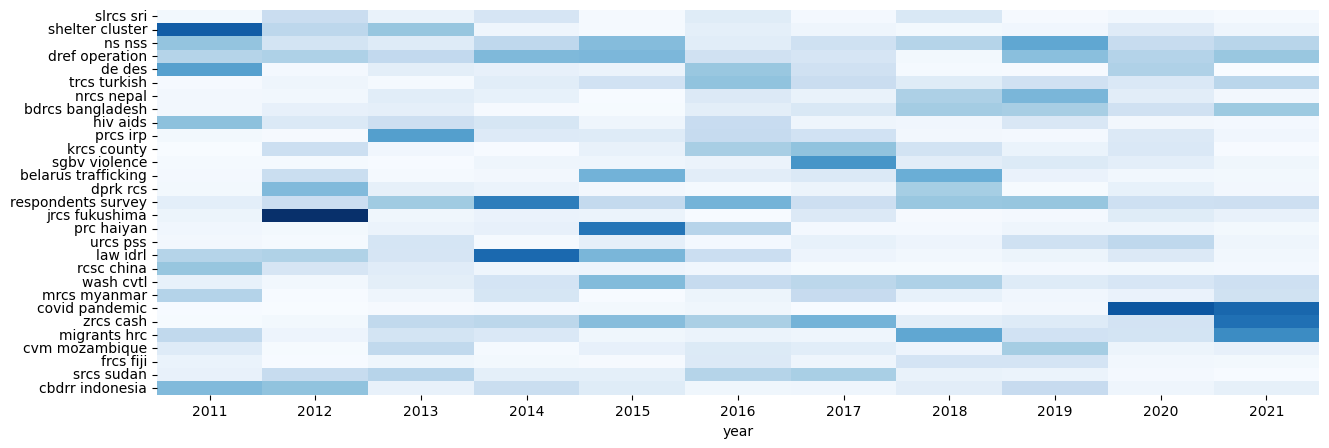

In [34]:
#display the chart
df_display = df_chrt
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(data=df_display.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Blues")


# By Topic @ sentence-Level Granularity


In [35]:
print(df_sentences.shape) ## content
print(df_topic_info__sent.shape) ## topics
print(normalized_topic_matrix__sent.shape) ## matrix of topic strengths
print(df_topic_summary__sent.shape) ## dominant topic

(275567, 6)
(30, 10)
(275567, 30)
(275567, 5)


In [44]:
def format_df_for_charting(matrix, df_topics, df_payload):
    
    topic_headers = df_topics['title'].unique().tolist()
    #join the headers and matrix together in one DF
    df_topics_and_strengths = pd.DataFrame(matrix, columns=topic_headers)

    #then merge them with the file data dataframe... dropping a few unecessary columns
    df_files_and_topics_for_charting = df_payload.merge(df_topics_and_strengths, left_index=True, right_index=True)
    df_files_and_topics_for_charting.drop(inplace=True, columns=['file','original_text'])
    
    return df_files_and_topics_for_charting

In [51]:
df_chrt = format_df_for_charting(normalized_topic_matrix__sent,df_topic_info__sent,df_sentences)
df_chrt.drop(inplace=True, columns=['preprocessed_text','preprocessed','num_tokens','de la'])

In [52]:
df_chrt

,year,need assessment,red cross,evaluation final,key group,community member,project implementation,support technical,shelter cluster,volunteer staff,...,level local,activity implement,review team,response yes,work time,capacity building,training receive,provide information,plan action,disaster management
0,2003,0.000000,0.598469,0.215630,0.000000,0.0,0.000000,0.000000,0.013568,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013189
1,2003,0.000000,0.998937,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.001063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2003,0.000000,0.329041,0.000000,0.000000,0.0,0.000000,0.001453,0.000000,0.000000,...,0.001349,0.000000,0.000000,0.006347,0.000000,0.004189,0.000000,0.000000,0.065327,0.135105
3,2003,0.001323,0.003415,0.006414,0.167091,0.0,0.000000,0.000000,0.023335,0.001281,...,0.000000,0.059597,0.014105,0.000000,0.001100,0.000000,0.000000,0.078336,0.060282,0.054512
4,2003,0.000000,0.000000,0.000000,0.000000,0.0,0.038810,0.000000,0.089513,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029892,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275562,2022,0.000000,0.000000,0.001349,0.000000,0.0,0.934518,0.000000,0.000000,0.000000,...,0.000000,0.011907,0.000000,0.000000,0.000000,0.016114,0.000000,0.000000,0.000000,0.000000
275563,2022,0.000000,0.013583,0.161405,0.680936,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.072011,0.000000,0.000000,0.000000,0.071538,0.000000,0.000000
275564,2022,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.007390,0.000000,0.000000,...,0.000000,0.000000,0.001124,0.000000,0.006048,0.000000,0.000000,0.963384,0.000000,0.000000
275565,2022,0.008506,0.009515,0.087291,0.000000,0.0,0.000000,0.003006,0.000000,0.031136,...,0.000000,0.103018,0.036964,0.063610,0.335358,0.010054,0.000000,0.000000,0.000200,0.000000


In [53]:
df_chrt = df_chrt.groupby('year').mean()
#df_chrt = df_chrt.iloc[8:-1]

<Axes: xlabel='year'>

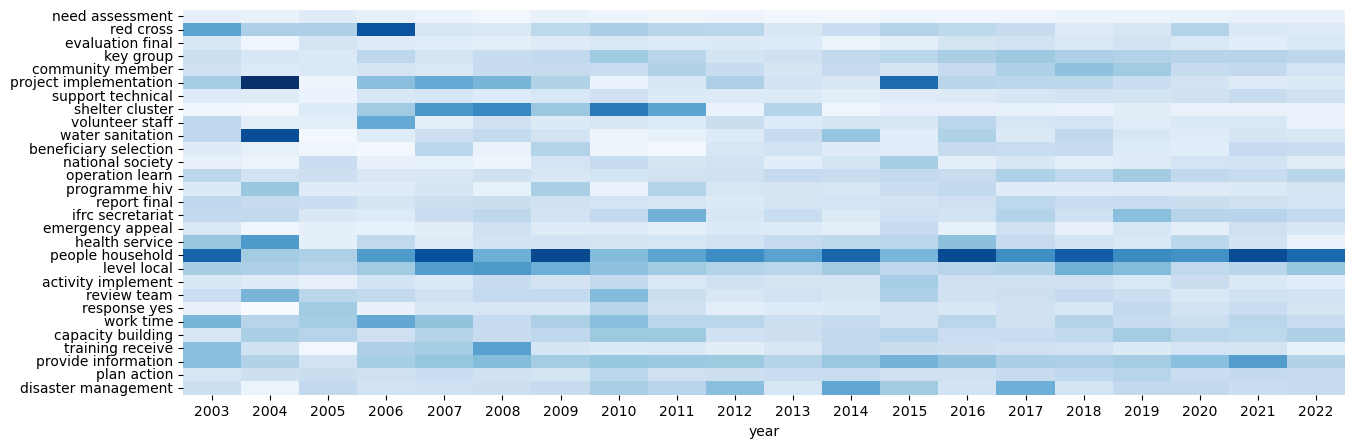

In [54]:
#display the chart
df_display = df_chrt
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(data=df_display.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Blues")

In [58]:
df_topic_info__sent[['title','keywords']].sort_values(by='title')

,title,keywords
21,activity implement,"activity, implement, livelihood, carry, program, time, implementation, include"
11,beneficiary selection,"beneficiary, selection, cash, process, communication, criterion, receive, satisfaction"
25,capacity building,"capacity, building, ns, build, resource, strengthen, development, increase"
5,community member,"community, member, base, resilience, center, engagement, centre, target"
1,de la,"de, la, en, el, los, las, que, del"
29,disaster management,"disaster, management, risk, reduction, law, preparedness, international, gender"
17,emergency appeal,"emergency, appeal, phase, relief, fund, recovery, launch, chf"
3,evaluation final,"evaluation, final, team, objective, monitoring, purpose, methodology, process"
18,health service,"health, service, care, public, education, facility, hygiene, promotion"
16,ifrc secretariat,"ifrc, secretariat, pns, office, country, geneva, org, icrc"
